## Explore peak data

These are the peak calls from running the chipseq-wf with all S2 cell chip data in the SRA. I remove phantom peaks, and plot the distribution of peak counts for TF/histones. I then filter for datasets with less than 1000 peaks. 

In [1]:
import pandas as pd
import seaborn as sb
import glob
import os
import pybedtools
from pybedtools.featurefuncs import gff2bed

In [2]:
#dropping this dataset -- 4 of the samples have 0 reads after cutadapt
throw_out = ['ERX242704', 'ERX242706', 'ERX242707','ERX242709', 'ERX242710','ERX242711','ERX242712','ERX242713',
             'ERX242715', 'ERX242716', 'ERX242717', 'ERX242718','ERX242722', 'ERX242723', 'ERX242724', 'ERX242726',
             'ERX242727', 'ERX242728', 'ERX242729']

Import the peak calls:

In [3]:
#all peaks would be glob.glob('../chipseq-wf/data/chipseq_peaks/*/[S,E]RX*/peaks.bed')
#macs2 peaks
concat = []
for fname in glob.glob('../chipseq-wf/data/chipseq_peaks/macs2/[S,E]RX*/peaks.bed'):
    name = fname.split('../chipseq-wf/data/chipseq_peaks/macs2/')[1].split('/peaks.bed')[0]
    if name not in throw_out:
        df = pd.read_table(fname, header=None)
        df['srx'] = name
        df['caller'] = 'macs2'
        concat.append(df)
macs2_full = pd.concat(concat)

In [4]:
macs2 = macs2_full[[0,1,2,'srx',8,'caller']]

In [5]:
#spp peaks
glob.glob('../chipseq-wf/data/chipseq_peaks/spp/[S,E]RX*/peaks.bed')
concat = []
for fname in glob.glob('../chipseq-wf/data/chipseq_peaks/spp/[S,E]RX*/peaks.bed'):
    name = fname.split('../chipseq-wf/data/chipseq_peaks/spp/')[1].split('/peaks.bed')[0]
    if name not in throw_out:
        if os.path.getsize(fname) != 0:
            df = pd.read_table(fname, header=None)
            df['srx'] = name
            df['caller'] = 'spp'
            concat.append(df)
spp_full = pd.concat(concat)

In [6]:
spp = spp_full[[0,1,2,'srx',8,'caller']]
spp[[1,2]]= spp[[1,2]].astype(int)

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Look at distributions of peak counts:

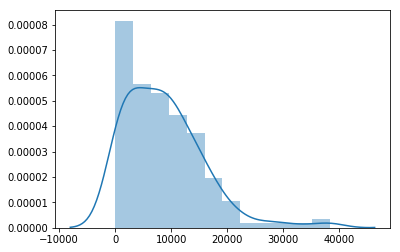

In [7]:
#Count number of peaks per dataset macs2 
peakcount_macs = macs2.groupby('srx')[[1]].count()
sb.distplot(peakcount_macs)

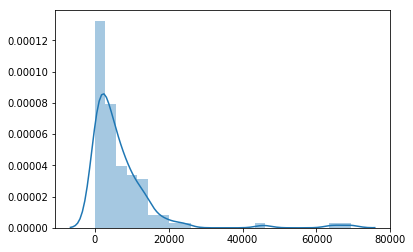

In [8]:
#Count number of peaks per dataset spp
peakcount_spp = spp.groupby('srx')[[1]].count()
sb.distplot(peakcount_spp)

In [9]:
both = pd.concat([macs2, spp])
#note: score is -log10 qvalue
both.columns = ['chrom','start','end','name','score','caller']
both.head()

,chrom,start,end,name,score,caller
0,chr2L,16617,16893,SRX191913,33.40816,macs2
1,chr2L,18490,19713,SRX191913,17.81555,macs2
2,chr2L,21242,21484,SRX191913,7.92056,macs2
3,chr2L,34118,34304,SRX191913,4.27362,macs2
4,chr2L,35499,35830,SRX191913,39.60189,macs2


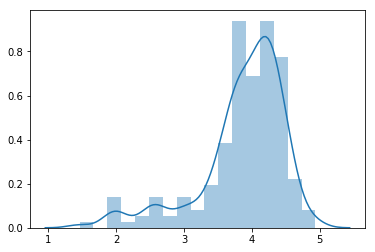

In [10]:
#log 10 peak count distribution for all peak data
import numpy

peakcount = both.groupby('name')[['start']].count()
sb.distplot(numpy.log10(peakcount + 1))


In [11]:
peakcount.describe()

,start
count,177.000000
mean,13595.090395
std,13067.106884
min,28.000000
25%,4822.000000
50%,10419.000000
75%,19345.000000
max,86662.000000


### Remove phantom peaks

Using spreadsheet from Supplementary Data, Jain et al 2014

In [12]:
phantompeaks = pd.read_excel(
    '../output/chip/gkv637_Supplementary_Data/Supplementary_table_3__List_of_Phantom_Peaks.xlsx')
phantompeaks = phantompeaks[['chr ','start','end','Name']]

In [13]:
# Get peak data in bed format
both = both[~both['start'].astype(str).str.contains('-')]
bed = both[['chrom','start','end','name']]

In [14]:
intersect = pybedtools.BedTool.from_dataframe(bed).intersect(pybedtools.BedTool.from_dataframe(phantompeaks), 
                                                             wo=True).to_dataframe()

In [15]:
#filter for an overlap of at least 50bp based on Jain et al 2014
filtered = intersect[intersect.itemRgb >= 50]

In [16]:
filtered.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb
0,chr2L,18490,19713,SRX191913,chr2L,18637,19089,Phantom Peak-1,452
1,chr2L,102214,102424,SRX191913,chr2L,102118,102570,Phantom Peak-2,210
2,chr2L,107113,109566,SRX191913,chr2L,107669,108121,Phantom Peak-3,452
3,chr2L,158896,159714,SRX191913,chr2L,158670,159126,Phantom Peak-6,230
4,chr2L,207224,207532,SRX191913,chr2L,207139,207591,Phantom Peak-8,308


In [17]:
outermerge = both.merge(filtered, how='outer', on=['chrom','start','end','name'], indicator=True)

In [18]:
no_phantom = outermerge[outermerge._merge == 'left_only'][['chrom','start','end','name','score_x','caller']]
no_phantom.rename(columns={'score_x': 'score'}, inplace=True)
no_phantom.head()

,chrom,start,end,name,score,caller
0,chr2L,16617,16893,SRX191913,33.40816,macs2
2,chr2L,21242,21484,SRX191913,7.92056,macs2
3,chr2L,34118,34304,SRX191913,4.27362,macs2
4,chr2L,35499,35830,SRX191913,39.60189,macs2
5,chr2L,43248,43463,SRX191913,3.57781,macs2


In [19]:
no_phantom.shape

(2276611, 6)

In [20]:
nophtm_peakcount = no_phantom.groupby('name').start.count()
nophtm_peakcount.describe()

count      177.000000
mean     12862.209040
std      12659.959969
min         27.000000
25%       4482.000000
50%       9506.000000
75%      18754.000000
max      85755.000000
Name: start, dtype: float64

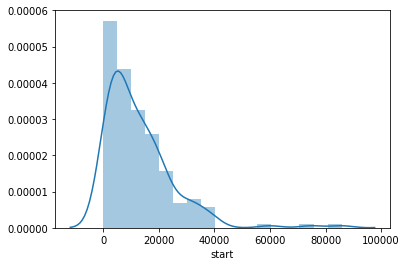

In [21]:
sb.distplot(nophtm_peakcount)

### Separate by TF/Histone
Import csv with metadata:

In [22]:
spreadsheet = pd.read_csv('../output/chip/20171103_s2cell_chip-seq.csv')

#For now we are excluding datasets with no input: 
spreadsheet = spreadsheet[spreadsheet.input != 'no input?']
spreadsheet.head()

,srx,cell_line,geo,paper,strategy,antibody,target,srr,chromatin,input,Unnamed: 10
0,SRX191913,S2 DRSC: Schneider's line 2,GSM1015410,"['24055367', '24055367']",ChIP-Seq,dCTCF antibody 68 (rat),CTCF,SRR580343,1,SRX191915,NaN
1,SRX191914,S2 DRSC: Schneider's line 2,GSM1015411,"['24055367', '24055367']",ChIP-Seq,dCTCF antibody 68 (rat),CTCF,SRR580344,1,SRX191916,NaN
2,SRX191915,S2 DRSC: Schneider's line 2,GSM1015412,"['24055367', '24055367']",ChIP-Seq,input,input,SRR580345,1,SRX191915,NaN
3,SRX191916,S2 DRSC: Schneider's line 2,GSM1015413,"['24055367', '24055367']",ChIP-Seq,input,input,SRR580346,1,SRX191916,NaN
4,SRX193308,Schneider's Drosophila Line 2; S2 cells,GSM1017394,"['23166019', '23166019']",ChIP-Seq,input,input,SRR585041,1,SRX193308,NaN


In [23]:
all_chromatin = spreadsheet[spreadsheet.chromatin == 1]
no_chromatin = spreadsheet[spreadsheet.chromatin == 0]

In [24]:
chromatin_nophantom = no_phantom[no_phantom.name.isin(all_chromatin.srx.values)]
tf_nophantom = no_phantom[no_phantom.name.isin(no_chromatin.srx.values)]

In [25]:
chr_peakcount = chromatin_nophantom.groupby('name').start.count()
chr_peakcount.describe()

count       41.000000
mean      8530.317073
std       8535.606497
min         27.000000
25%       4917.000000
50%       6031.000000
75%       9055.000000
max      37610.000000
Name: start, dtype: float64

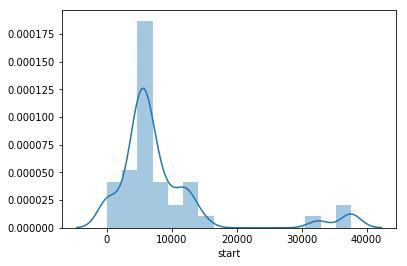

In [26]:
sb.distplot(chr_peakcount)

In [27]:
tf_peakcount = tf_nophantom.groupby('name').start.count()
tf_peakcount.describe()

count      136.000000
mean     14168.147059
std      13414.404307
min         83.000000
25%       3937.250000
50%      12149.500000
75%      19892.750000
max      85755.000000
Name: start, dtype: float64

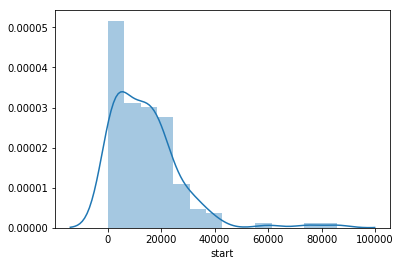

In [28]:
sb.distplot(tf_peakcount)

## Filter by peak count

Remove datasets with less than 1000 peaks:

In [29]:
tf_peakcount[tf_peakcount < 1000]

name
ERX402112      83
ERX402114     931
ERX402138     129
SRX018629     468
SRX018630     271
SRX018631     286
SRX018632     303
SRX1389384     92
SRX1389387    300
SRX1433399    820
SRX149190     905
SRX330269     109
SRX330270      86
SRX883604     496
SRX883605     402
Name: start, dtype: int64

In [30]:
chr_peakcount[chr_peakcount < 1000]

name
SRX2055956     83
SRX2055959    325
SRX2055962    238
SRX2417577     27
Name: start, dtype: int64

In [31]:
i1 = tf_peakcount[tf_peakcount < 1000].index
i2 = chr_peakcount[chr_peakcount < 1000].index

In [32]:
filtered_tf_np = tf_nophantom[~tf_nophantom.name.isin(i1)]
filtered_chr_np = chromatin_nophantom[~chromatin_nophantom.name.isin(i2)]

In [33]:
filtered_tf_np.groupby('name').count().describe()

,chrom,start,end,score,caller
count,121.000000,121.000000,121.000000,121.000000,121.000000
mean,15877.578512,15877.578512,15877.578512,15877.578512,15877.578512
std,13255.728763,13255.728763,13255.728763,13255.728763,13255.728763
min,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000
25%,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000
50%,14154.000000,14154.000000,14154.000000,14154.000000,14154.000000
75%,20360.000000,20360.000000,20360.000000,20360.000000,20360.000000
max,85755.000000,85755.000000,85755.000000,85755.000000,85755.000000


In [34]:
filtered_chr_np.groupby('name').count().describe()

,chrom,start,end,score,caller
count,37.000000,37.000000,37.000000,37.000000,37.000000
mean,9434.324324,9434.324324,9434.324324,9434.324324,9434.324324
std,8505.345274,8505.345274,8505.345274,8505.345274,8505.345274
min,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000
25%,5161.000000,5161.000000,5161.000000,5161.000000,5161.000000
50%,6315.000000,6315.000000,6315.000000,6315.000000,6315.000000
75%,10022.000000,10022.000000,10022.000000,10022.000000,10022.000000
max,37610.000000,37610.000000,37610.000000,37610.000000,37610.000000


In [35]:
filtered_tf_np.to_csv('../output/chip/ALL_TF_CHIP_filtered.bed', header=False,index=False, sep='\t')

In [36]:
filtered_chr_np.to_csv('../output/chip/ALL_HIST_CHIP_filtered.bed', header=False,index=False, sep='\t')

Empty spp sets, confirmed that all of these are from "bad datasets": 

In [38]:
empty_updated = []
for fname in glob.glob('../chipseq-wf/data/chipseq_peaks/spp/[S,E]RX*/peaks.bed'):
    if os.path.getsize(fname) == 0:
        name = fname.split('../chipseq-wf/data/chipseq_peaks/spp/')[1].split('/peaks.bed')[0]
        empty_updated.append(name)
        
len(empty_updated)

20

In [39]:
empty_updated

['ERX242724',
 'ERX242711',
 'ERX242728',
 'ERX242727',
 'ERX242704',
 'ERX242713',
 'ERX402137',
 'ERX402138',
 'SRX883604',
 'SRX1389384',
 'ERX402108',
 'SRX330269',
 'ERX402133',
 'ERX402112',
 'SRX1389387',
 'SRX330270',
 'ERX242712',
 'SRX359798',
 'SRX1389388',
 'ERX402114']

In [40]:
emptydf = pd.DataFrame(empty_updated, columns=['srx'])

In [41]:
spreadsheet.merge(emptydf, how='inner')[['srx','geo','target','srr','input']]

,srx,geo,target,srr,input
0,SRX330269,GSM1199044,EcR,SRR946215 | SRR946214,SRX330271
1,SRX330270,GSM1199045,EcR,SRR946216 | SRR946217,SRX330271
2,SRX359798,GSM1239359,AGO2,SRR1002330,SRX359796
3,SRX883604,GSM1614137,Tet,SRR1810946,SRX883600
4,SRX1389384,GSM1919989,control,SRR2834290 | SRR2834288 | SRR2834289,SRX1389383
5,SRX1389387,GSM1919992,control,SRR2834295 | SRR2834296,SRX1389386
6,SRX1389388,GSM1919993,dCAP-D3,SRR2834297 | SRR2834298,SRX1389386
7,ERX242704,NaN,E2f,ERR268501,ERX242726
8,ERX242711,NaN,E2f,ERR268481,ERX242707
9,ERX242712,NaN,E2f,ERR268486,ERX242717
